In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!wget !wget https://www.cs.toronto.edu/~lczhang/413/raw_sentences.txt

--2024-02-26 04:28:49--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2024-02-26 04:28:49--  https://www.cs.toronto.edu/~lczhang/413/raw_sentences.txt
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2955731 (2.8M) [text/plain]
Saving to: ‘raw_sentences.txt’

raw_sentences.txt   100%[===================>]   2.82M  1.92MB/s    in 1.5s    

2024-02-26 04:28:51 (1.92 MB/s) - ‘raw_sentences.txt’ saved [2955731/2955731]

FINISHED --2024-02-26 04:28:51--
Total wall clock time: 2.5s
Downloaded: 1 files, 2.8M in 1.5s (1.92 MB/s)


In [4]:
sentences = []
for line in open('./raw_sentences.txt', 'r'):

      words = line.split()
      sentence = [word.lower() for word in words]
      sentences.append(sentence)

In [5]:
print("Number of sentences:", len(sentences))
vocab = set([word for sentence in sentences for word in sentence])
print("Size of vocabulary:", len(vocab))

Number of sentences: 97162
Size of vocabulary: 250


In [6]:
sentence_lengths = [len(sentence) for sentence in sentences]
print("Min length", np.min(sentence_lengths))
print("Average length", np.mean(sentence_lengths))
print("Max length", np.max(sentence_lengths))

Min length 4
Average length 7.792881990901793
Max length 43


In [7]:
from random import shuffle

shuffle(sentences)

train_data = sentences[:int(0.8 * len(sentences))]
val_data = sentences[int(0.8 * len(sentences)):int(0.9 * len(sentences))]
test_data = sentences[int(0.9 * len(sentences)):]

print(len(train_data), len(val_data), len(test_data))

77729 9716 9717


In [8]:
from collections import Counter

word_count = Counter([w for sentence in sentences for w in sentence])
print(word_count.most_common(5))

[('.', 80974), ('it', 29200), (',', 24583), ('i', 22267), ('do', 20245)]


In [9]:
# create vocab dictionary
vocab = set([w for sentence in sentences for w in sentence])
word_index = {w:i for i, w in enumerate(vocab)}

In [10]:
# convert words to indices

def words_to_indices(sentences):

  return [[word_index[word] for word in sentence] for sentence in sentences]

def generate_4grams(indices):

  four_grams = []
  for sentence in indices:
    for i in range(len(sentence) - 4):
      four_grams.append(sentence[i:i+4])

  return four_grams

def compile_data(sentences):
  indices = words_to_indices(sentences)
  four_grams = generate_4grams(indices)
  return np.array(four_grams)

grams = compile_data(train_data)
val_grams = compile_data(val_data)
print(grams.shape)

(294915, 4)


In [11]:
# one hot encoding the input

def onehot_encoder(four_grams, vocab_size):
  I = np.eye(vocab_size)
  return I[four_grams]

print(onehot_encoder(grams, len(vocab)).shape)

(294915, 4, 250)


In [12]:
def get_batch(data, range_min, range_max, onehot=True):

  X = data[range_min:range_max, :3]
  t = data[range_min:range_max, 3]

  X = onehot_encoder(X, len(vocab))

  X = X.reshape(-1, 3 * len(vocab))

  if onehot:
    t = onehot_encoder(t, len(vocab))
    t = t.reshape(-1, len(vocab))

  return X, t

# test the data out

grams = compile_data(train_data)
X, t = get_batch(grams, 0, 10, onehot=False)
print(X.shape, t.shape)

# check if indices are at the right position
for i in range(3):
  index_pos = grams[0][i]
  print(X[0][index_pos + ((len(vocab) * i) - 1)]) # should be 0
  print(X[0][index_pos + (len(vocab) * i)]) # should 1
  print(X[0][index_pos + ((len(vocab) * i) + 1)]) # should be 0

(10, 750) (10,)
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0


In [13]:
def accuracy(model, data, batch=100, max_N=10000):
  num_correct = 0
  num_pred = 0

  for i in range(0, data.shape[0], batch):
    X, t = get_batch(data, i, i+1, onehot=False)
    z = model.forward(X)
    pred = np.argmax(z, axis=1)

    num_correct += np.sum(pred == t)
    num_pred += t.shape[0]

    if num_pred >= max_N:
      break

  return num_correct / num_pred

In [14]:
def softmax(x):

  x = x.T
  exps = np.exp(x - x.max(axis=0))
  probs = exps / np.sum(exps, axis=0)
  return probs.T

In [15]:
class NNModel:

  def __init__(self, vocab_size, emb_size, num_hidden):

    self.vocab_size = vocab_size
    self.emb_size = emb_size
    self.num_hidden = num_hidden

    self.Ww = np.zeros([vocab_size, emb_size])
    # self.bw = np.zeros([emb_size])

    self.W1 = np.zeros([emb_size * 3, num_hidden])
    self.b1 = np.zeros([num_hidden])

    self.W2 = np.zeros([num_hidden, vocab_size])
    self.b2 = np.zeros([vocab_size])

    self.initialize_weights()

    self.cleanup()

  def initialize_weights(self):

    self.Ww = np.random.normal(0, 2/(self.vocab_size), self.Ww.shape)

    self.W1 = np.random.normal(0, 2/(3*self.emb_size), self.W1.shape)
    self.b1 = np.random.normal(0, 2/(3*self.emb_size), self.b1.shape)

    self.W2 = np.random.normal(0, 2/(self.num_hidden), self.W2.shape)
    self.b2 = np.random.normal(0, 2/(self.num_hidden), self.b2.shape)

  def cleanup(self):

    self.N = None
    self.xa = None
    self.xb = None
    self.xc = None
    self.va = None
    self.vb = None
    self.vc = None
    self.v = None
    self.m = None
    self.h = None
    self.z = None
    self.y = None

    self.z_bar = None
    self.W2_bar = None
    self.b2_bar = None
    self.h_bar = None
    self.m_bar = None
    self.W1_bar = None
    self.b1_bar = None
    self.v_bar = None
    self.va_bar = None
    self.vb_bar = None
    self.vc_bar = None
    self.Ww_bar = None


  def forward(self, X):

    return do_forward_pass(self, X)

  def backward(self, t):

    return do_backward_pass(self, t)

  def loss(self, t):

    # Cross Entropy Loss
    pred = np.sum(-t * np.log(self.y)) / t.shape[0]
    return pred

  def update(self, alpha):

    self.Ww = self.Ww - alpha * self.Ww_bar
    self.W1 = self.W1 - alpha * self.W1_bar
    self.b1 = self.b1 - alpha * self.b1_bar
    self.W2 = self.W2 - alpha * self.W2_bar
    self.b2 = self.b2 - alpha * self.b2_bar

In [16]:
def do_forward_pass(model, X):

  model.N = X.shape[0]
  model.X = X

  model.xa = X[:, 0:model.vocab_size]
  model.xb = X[:, model.vocab_size:2*model.vocab_size]
  model.xc = X[:, 2*model.vocab_size:]

  # compute embeddings
  model.va = np.matmul(model.xa, model.Ww)
  model.vb = np.matmul(model.xb, model.Ww)
  model.vc = np.matmul(model.xc, model.Ww)
  model.v = np.concatenate([model.va, model.vb, model.vc], axis=1)

  # print(model.v.shape)

  # compute pre-hidden layer input
  model.m = np.matmul(model.v, model.W1) + model.b1

  # compute post hidden layer - ReLU activation
  model.h = np.maximum(0, model.m)

  # compute logits
  model.z = np.matmul(model.h, model.W2) + model.b2

  # compute class probabilities
  model.y = softmax(model.z)

  return model.z

In [17]:
x, t = get_batch(grams, 0, 10)
model = NNModel(len(vocab), 250, 100)
y = model.forward(x)

print(model.va.shape, model.vb.shape, model.vc.shape)
print(model.v.shape)
print(model.z.shape)
print(model.z.shape)

(10, 250) (10, 250) (10, 250)
(10, 750)
(10, 250)
(10, 250)


In [18]:
print(accuracy(model, grams))

0.00711864406779661


In [22]:
def do_backward_pass(model, t):
  """
  Compute the backward pass, given the ground-truth, one-hot targets.

  The quantities computed by `model.forward()` are accessible to this function.

  The member variables of this function will be used in the 'update()' function.

  Parameters:
      `model` - An instance of NNModel
      `t` - A numpy array of shape (N, model.num_classes)
  """

  model.z_bar = (model.y - t) / model.N
  model.W2_bar = np.dot(model.h.T, model.z_bar)
  model.b2_bar = np.dot(np.ones(model.N).T, model.z_bar)
  model.h_bar = np.matmul(model.z_bar, model.W2.T)
  model.m_bar = model.h_bar * (model.m > 0)

  model.W1_bar = np.dot(model.v.T, model.m_bar)
  model.b1_bar = np.dot(np.ones(model.N).T, model.m_bar)


  model.v_bar = np.matmul(model.m_bar, model.W1.T)


  model.va_bar = model.v_bar[:, 0:model.vocab_size]
  model.vb_bar = model.v_bar[:, model.vocab_size:2*model.vocab_size]
  model.vc_bar = model.v_bar[:, 2*model.vocab_size:]

  model.Ww_bar = np.dot(model.xa.T, model.va_bar) + np.dot(model.xb.T, model.vb_bar) + np.dot(model.xc.T, model.vc_bar)

  return model

In [20]:
x_, t_ = get_batch(grams, 0, 8)
model = NNModel(len(vocab), 250, 100)

model.forward(x_)
model.backward(t_)
model.update(0.001)

(8, 100) (100, 750)
(8, 750)


Iter 1000. Acc [val:0.04632152588555858, train:0.04711864406779661] Loss 4.844107858111808]
Iter 2000. Acc [val:0.04632152588555858, train:0.04711864406779661] Loss 4.784819535231652]
Iter 3000. Acc [val:0.04632152588555858, train:0.04271186440677966] Loss 4.799271955109264]
Iter 4000. Acc [val:0.04632152588555858, train:0.04271186440677966] Loss 4.737072183396049]
Iter 5000. Acc [val:0.04632152588555858, train:0.04271186440677966] Loss 4.690316797469802]
Iter 6000. Acc [val:0.043596730245231606, train:0.04305084745762712] Loss 4.652495705282858]
Iter 7000. Acc [val:0.08991825613079019, train:0.08949152542372882] Loss 4.757155247708229]
Iter 8000. Acc [val:0.09809264305177112, train:0.10067796610169491] Loss 4.5604626837231645]
Iter 9000. Acc [val:0.10899182561307902, train:0.10372881355932204] Loss 4.338677968878169]
Iter 10000. Acc [val:0.12534059945504086, train:0.13457627118644067] Loss 4.2061310488103025]
Iter 11000. Acc [val:0.1362397820163488, train:0.14915254237288136] Loss 4.1

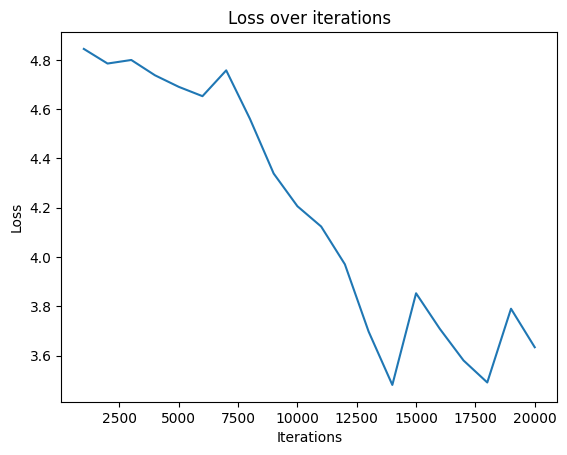

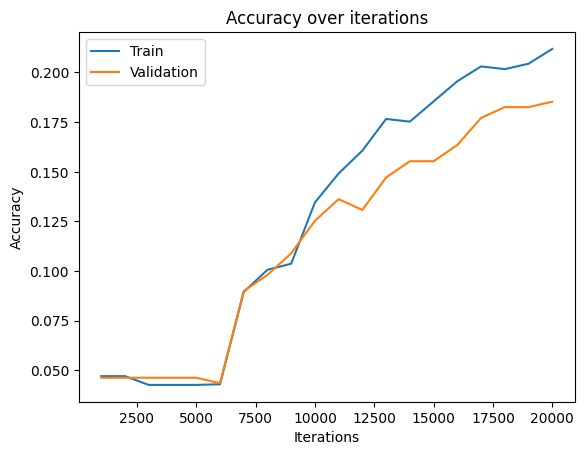

In [33]:
def train_model(model, train_data=grams, validation_data=val_grams, batch_size=100, learning_rate=0.05, max_iters=20000, plot_every=1000):
    """
    Use gradient descent to train the numpy model on the dataset train4grams.
    """
    iters, train_loss, train_acc, val_acc = [], [], [], [] # for the training curve
    iter_count = 0  # count the number of iterations
    try:
      while iter_count < max_iters:
          # shuffle the training data, and break early if we don't have
          # enough data to remaining in the batch
          np.random.shuffle(train_data)
          for i in range(0, train_data.shape[0], batch_size):
              if (i + batch_size) > train_data.shape[0]:
                  break

              xs, ts = get_batch(train_data, i, i + batch_size, onehot=True)
              model.cleanup() # start with fresh gradients

              ys = model.forward(xs)
              model.backward(ts)

              model.update(learning_rate)

              # increment the iteration count
              iter_count += 1


              # collect stats for model's learning
              if (iter_count % plot_every == 0):
                  iters.append(iter_count)
                  train_loss.append(model.loss(ts))
                  train_acc.append(accuracy(model, train_data))
                  val_acc.append(accuracy(model, validation_data))
                  # model.cleanup()
                  print(f"Iter {iter_count}. Acc [val:{val_acc[-1]}, train:{train_acc[-1]}] Loss {train_loss[-1]}]")

              if iter_count >= max_iters:
                  break

    finally:
      plt.figure()
      plt.plot(iters[:len(train_loss)], train_loss)
      plt.title("Loss over iterations")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")

      plt.figure()
      plt.plot(iters[:len(train_acc)], train_acc)
      plt.plot(iters[:len(val_acc)], val_acc)
      plt.title("Accuracy over iterations")
      plt.xlabel("Iterations")
      plt.ylabel("Accuracy")
      plt.legend(["Train", "Validation"])




In [35]:
!wget https://www.cs.toronto.edu/~lczhang/413/sentence_pretrained.pk

--2024-02-26 04:58:29--  https://www.cs.toronto.edu/~lczhang/413/sentence_pretrained.pk
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 863119 (843K) [application/x-tex-pk]
Saving to: ‘sentence_pretrained.pk’

sentence_pretrained 100%[===================>] 842.89K   744KB/s    in 1.1s    

2024-02-26 04:58:31 (744 KB/s) - ‘sentence_pretrained.pk’ saved [863119/863119]



In [37]:
test_grams = compile_data(test_data)
accuracy(model, test_grams)

0.1972972972972973

There's still a lot of scope for improvement of this model. Next, I can look into hyper parameters tuning to increase the accuracy
